# Pré-processamento dos dados

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.Resize(size = (224,224)), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
train = '1Amostragem/train'
test = '1Amostragem/test'

In [4]:
train_dataset = datasets.ImageFolder(train, transform = transform)
test_dataset = datasets.ImageFolder(test, transform = transform)

In [5]:
trainloader = DataLoader(train_dataset, batch_size = 10, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = 50, shuffle = False)

# Implementação da arquitetura CNN

In [6]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Flatten(),
    nn.Linear(32 * 56 * 56, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)        

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=100352, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
  (10): Sigmoid()
)

In [8]:
num_epoch = 20
learning_rate = 0.001
train_losses = []

In [9]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

In [10]:
for epoch in range(num_epoch):
    model.train()
    running_train_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(trainloader)
    train_losses.append(train_loss)
    
    print(f"Época {epoch + 1}/{num_epoch} - Perda no treinamento: {train_loss:.6f}")

Época 1/20 - Perda no treinamento: 1.255741
Época 2/20 - Perda no treinamento: 0.488617
Época 3/20 - Perda no treinamento: 0.262424
Época 4/20 - Perda no treinamento: 0.111441
Época 5/20 - Perda no treinamento: 0.039687
Época 6/20 - Perda no treinamento: 0.010777
Época 7/20 - Perda no treinamento: 0.003031
Época 8/20 - Perda no treinamento: 0.000999
Época 9/20 - Perda no treinamento: 0.000415
Época 10/20 - Perda no treinamento: 0.000242
Época 11/20 - Perda no treinamento: 0.000162
Época 12/20 - Perda no treinamento: 0.000114
Época 13/20 - Perda no treinamento: 0.000085
Época 14/20 - Perda no treinamento: 0.000066
Época 15/20 - Perda no treinamento: 0.000057
Época 16/20 - Perda no treinamento: 0.000047
Época 17/20 - Perda no treinamento: 0.000045
Época 18/20 - Perda no treinamento: 0.000037
Época 19/20 - Perda no treinamento: 0.000032
Época 20/20 - Perda no treinamento: 0.000029


In [11]:
model.eval()
correct = 0
total = 0
    
with torch.no_grad():
        
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc = (correct / total) * 100
print(f"Acurácia: {acc:.2f}%")

Acurácia: 90.00%


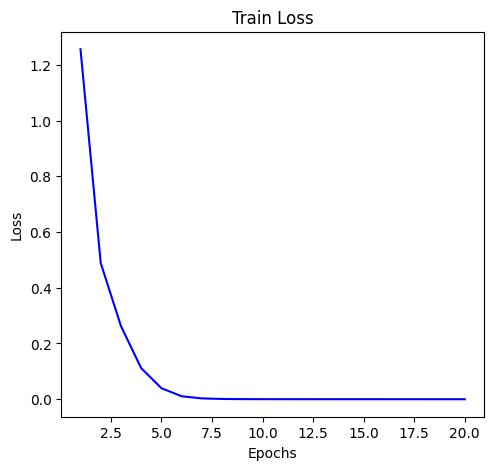

In [12]:
epochs = range(1, 21)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

# Métricas de avaliação

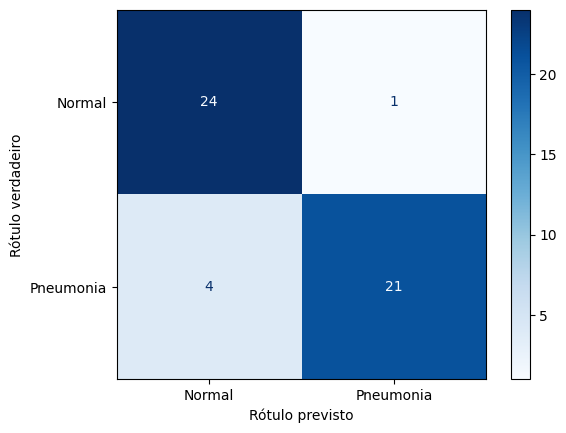

In [13]:
cm = confusion_matrix(labels, predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.show()

In [18]:
accuracy = accuracy_score(labels, predicted)
print(f"Acurácia: {accuracy:.2f}")

Acurácia: 0.90


In [17]:
precision = precision_score(labels, predicted, average='weighted')
print(f"Precisão: {precision:.2f}")

Precisão: 0.91


In [31]:
recall = recall_score(labels, predicted, average='weighted')
print(f"Recall: {recall:.2f}")

Recall: 0.90


In [28]:
f1 = f1_score(labels, predicted, average='weighted')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.90


AUC-ROC: 0.90


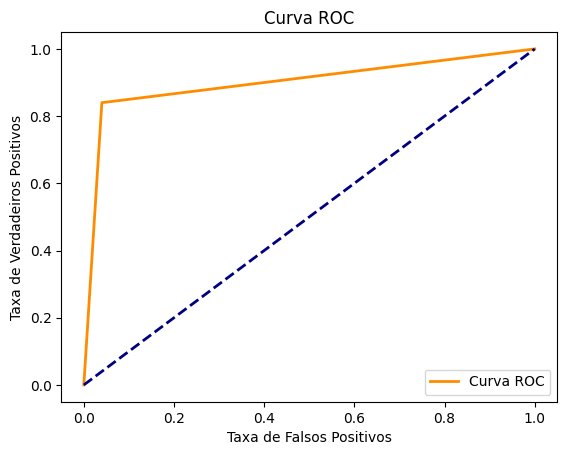

In [30]:
if len(train_dataset.classes) == 2:
    auc_roc = roc_auc_score(labels, predicted)
    print(f"AUC-ROC: {auc_roc:.2f}")

    fpr, tpr, _ = roc_curve(labels, predicted)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()